# Continuous Control

---

In this notebook, I present my DDPG solution to the second project, Continuous Control, of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


## About the enviroment and the agents
The enviroment contain 20 independent agents, each control a double jointed arm. The goal of the project is to train the agents to control the arms to track the target locations. 

### The reward dynamic and the goal of the agents
A reward of +0.1 is provided for each step that the agent's hand is in the goal location. The goal is to maintain its positiion at the target location to maximise total reward.

### State space
The state space for each agent is described discretely by 33 state values (a 1D-vector of size 33), correspondingto position, rotation, velocity, and angular velocities of the arm(s).

### Action space
4 continuous variables (a 1D-vector of size 4) describe the action space for each agent. The values correspond to torque applicable to the two joints. Every entry in the action vector is a number between -1 and 1. 

### Termination of the episode
The task is episodic, it is terminated at the maximum number of time step (1001), when the accumuated reward is counted as the final reward. 

### Success criteria
The sucess criteria is achieving an average score of +30 over 100 consecutive episodes, across all the 20 agents.

## The agent (the learning algorithm)
_dqn_agent.py_ defines the Agent, it learns with the Deep Deterministic Policy Gradient (DDPG) method, with Experience Replay and delayed Target Network update techniques.

### About DDPG
This implementation uses the DDPG method. I understand DDPG as an extension of Deep Q-Network learning, applicable to discrete action spaces, to continuous action spaces. DDPG is also introduced as one of the Actor-Critic method as it uses the critic network (value funciton) to aid training of the action network. The Actor network tries to find the policy in the continuous space; while the Critic network is used to estimate the Q value (the max expected reward) with respect to the continuous actions. There is a very good explanation of DDPG from [this page](https://github.com/udacity/deep-reinforcement-learning#dependencies).

### About Experience Replay
In Deep Q-Learning, Experience Replay is commonly used to break the correlation between consequent states and actions. It is about caching past experiences (action, reward and next state sets), and then sampling them randomly to feed the learning algorithm. In this particular implementation, the experiences from 20 independent agents are stacked and randomised before fed back to the learning of all 20 agents.

### About Delayed Target Network
In Deep Q-Learning, Double Q-Network techniques are commonly used, where the target network is updated with delay to stablise Q value estimation. A soft update algorithm is used, where the target network weights are updated with a weighted average of the local network weights and the old target network weights.

### Loss function and optimisation
The mean square error loss is used in conjunction with the Adam optimiser.

### Noise add-on
An stochastic zero mean mean reverting random variable (OU Noise) is added to the policy generated actions to exploit un-explored territories (then clipped to between -1 and +1).

## About the models (the neural networks)
_ddpg_model.py_ is written in PyTorch, it defines the Neural Networks. There are 2 different networks - one for the Actor and the other for the Critic.

The Actor network is a deep network using 2 fully connected hidden layers (512 nodes each by default, but configurable through parameters _fc1_units_ and _fc2_units_ at initialisation stage) with ReLU activations. The input is the enviroment state (in this case a 1D-vector of size 33), while the output is the action (in this case a 1D-vector of size 4), with a tanh transform function.

The Critic network is a deep network using 2 fully connected hidden layers. The input is the enviroment state (in this case a 1D-vector of size 33). The first hidden layer is of size defined by fcs1_units+33 (fcs1_units defaults to 512). The second layer is of size defined by fc2_units (defaults to 512). Both layers have Leaky ReLU activation. The final outcome is a scalar (dimension 1), without any transformation. This represents the Q value corresponding to the continuous actions.

## Hyperparameters
The following are the hyperparameters used

- _BUFFER_SIZE_ defines the replay buffer size, default to 1e5
- _BATCH_SIZE_ defines minibatch size in learning, defaults to 64
- _GAMMA_ defines the discount factor in expected reward calculation, defauls to 0.99
- _TAU_ defines the weights for soft update of target parameters, defaults to 1e-3
- _LR_ACTOR_ defines learning rate of the actor, defaults to 1e-4
- _LR_CRITIC_ defines learning rate of the critic, defaults to 3e-4
- _WEIGHT_DECAY_ defines L2 weight decay, defaults to 0
- _LEARN_FREQ_ defines the frequency of learning, defaults to 10
- _LEARN_NUM_ defines the number of times learning is repeated per experience sample set, defaults to 20

### Saving the trained models
The trained parameters are saved in the files _checkpoint_actor_ddpg.pth_ and _checkpoint_actor_ddpg.pth_ for the Actor and Critic networks, respectively. Seperately, _checkpoint_actor_ddpg_gpu.pth_ and _checkpoint_actor_ddpg_gpu.pth_ store a set of model parameters that are obtained by training with the Udacity workspace GPU facility. The results and scores obtained by the GPU are very similar to those in the results, but understandably much quicker.

**Use the code below to replicate the solution.**
### Start the Environment
Set the Unity Enviroment path (Windows x64 executable)

In [1]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name=r'.\Reacher_Windows_x86_64_20\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Set the environments **_brain_**.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces
The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Training the agent

In [4]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch
import time

%matplotlib inline

agent = Agent(state_size, action_size, random_seed=1)

Device used:  cpu


In [5]:
def ddpg(n_episodes=300, max_t=1000, print_every=5, success_criteria_count=100):
    scores_deque = deque(maxlen=success_criteria_count)
    scores = []
    agent_mean_scores = []
    agent_mean_scores_100eps = []

    for i_episode in range(1, n_episodes+1):    
        start_t = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros((num_agents,))   
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]   
            next_state = env_info.vector_observations         
            reward = env_info.rewards                         
            done = env_info.local_done                
            agent.step(state, action, reward, next_state, done, t)
            state = next_state
            score += reward
            if np.any(done):
                break 
            
        scores_deque.append(score)
        scores.append(score)
        agent_mean_scores.append(np.mean(score))
        agent_mean_scores_100eps.append(np.mean(scores_deque))

        end_t = time.time()
               
        if np.mean(scores_deque)>=30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_ddpg.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_ddpg.pth')
            break
        if i_episode % print_every == 0:
            print('\rAgents Mean Score in Episode {:03d}: {:.2f}, \tAgents Mean Score over last 100 episodes: {:.2f} (time per eps:{:.1f} secs)'.format(i_episode,np.mean(score), np.mean(scores_deque), end_t - start_t), end="\n")
    return scores, agent_mean_scores, agent_mean_scores_100eps

scores, agent_mean_scores, agent_mean_scores_100eps = ddpg()


Agents Mean Score in Episode 005: 1.17, 	Agents Mean Score over last 100 episodes: 0.59 (time per eps:55.4 secs)
Agents Mean Score in Episode 010: 2.62, 	Agents Mean Score over last 100 episodes: 1.13 (time per eps:56.3 secs)
Agents Mean Score in Episode 015: 5.20, 	Agents Mean Score over last 100 episodes: 2.30 (time per eps:55.4 secs)
Agents Mean Score in Episode 020: 8.58, 	Agents Mean Score over last 100 episodes: 3.47 (time per eps:56.1 secs)
Agents Mean Score in Episode 025: 13.17, 	Agents Mean Score over last 100 episodes: 4.94 (time per eps:58.3 secs)
Agents Mean Score in Episode 030: 19.58, 	Agents Mean Score over last 100 episodes: 7.00 (time per eps:57.6 secs)
Agents Mean Score in Episode 035: 29.16, 	Agents Mean Score over last 100 episodes: 9.86 (time per eps:59.6 secs)
Agents Mean Score in Episode 040: 32.64, 	Agents Mean Score over last 100 episodes: 12.53 (time per eps:60.7 secs)
Agents Mean Score in Episode 045: 35.19, 	Agents Mean Score over last 100 episodes: 14.86 (

In [9]:
import pickle 
filehandler = open('score.pi', 'wb') 
score_dict = {"scores":scores, "agent_mean_scores": agent_mean_scores, "agent_mean_scores_100eps":agent_mean_scores_100eps}
pickle.dump(score_dict, filehandler)
filehandler.close()

### Plot the scores.

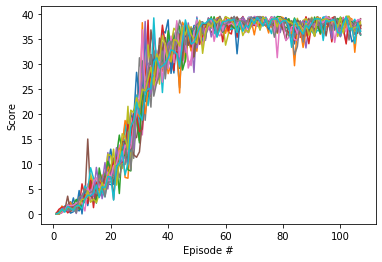

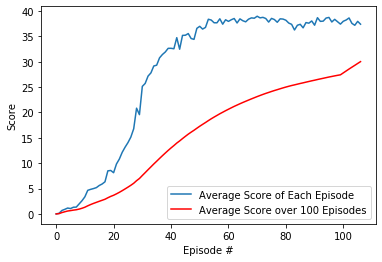

In [6]:
# plot the scores of every agent
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), agent_mean_scores, label='Average Score of Each Episode')
plt.plot(np.arange(len(scores)), agent_mean_scores_100eps, c='r', label='Average Score over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='lower right')
plt.show()

The problem is solved with just more than 100 episode. From the charts, it can be seen that the average agent score has become stable, around  38, after about 60 epsisodes.

In [7]:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_ddpg.pth')

### Seeing the trained agent in action

In [10]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_ddpg.pth'))
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i = 0
while True:
    i+=1
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print('Total number of timesteps: {:d}'.format(i))
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total number of timesteps: 1001
Total score (averaged over agents) this episode: 37.834499154333024


### Close the environment.

In [45]:
env.reset()
env.close()

## Future Improvements
During the course of solving this problem, I found the performance of DDPG to be highly sensitive to the following parameters:
- The learning rates
- Node counts in both the Actor and the Critic network
- The learning frequency and the number of repetitive updates per draw of experiences.

It is quite complex trying to optimise with so many parameters. I have presented the combination that I found to be the most efficient, which includes replacing the ReLU activation with Leaky ReLU.

However, I think the following are unexplored possibilities for imrpovement:
- Increase the number of layers in the Actor and Critic networks
- Use smaller or larger volaitlies in the OU Noise add-on

Last but not least, we can try other learning methods covered in the lessions, including but not limited to PPO, A3C/A2C and GAE